# KNN Model

The aim of this section is to train a neural network that can accurately classify the agency that responded to a 311 call. In the exploratory analysis section, we saw that none of the community districts' numeric indicators were highly correlated with any of the dummy-encoded agency categories. Intuitively, one may expect the call's descriptor to be the best predictor of the responding agency, but given that the descriptors consist of natural language data, they will need to undergo additional preprocessig before being fed into a model.

In [1]:
from tensorflow.random import set_seed
set_seed(9)
import numpy as np
np.random.seed(999)

# Loading Dependencies

In [2]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import random
import re

from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import models
from keras import layers
from keras import optimizers
from keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Activation, Dropout

# Importing the Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path = '/content/drive/MyDrive/Colab Notebooks/nyc_311_after2.csv' #change path to match your Google Drive file location
df = pd.read_csv(path, index_col=0)

# Assessing Model Performance

With perfectly balanced classes, a model's accuracy is acceptable if it exceeds the expected accuracy rate of simply picking a random class. With heavily imbalanced classes, however, a model's accuracy can instead be compared to that of picking the majority class. Below is the expected accuracy rate if we were to predict that all calls in a sample were responded to by the NYPD.

In [5]:
#divide count of NYPD calls by total calls and round to 2 decimal places
round(len(df[df.agency =='NYPD'])/len(df) * 100, 2)

51.37

While the aim will be to maximize model accuracy, any classifier that is at least 53% accurate will out-perform the simple assignment of all calls to the NYPD.

# Sampling the Data
The dataset currently consists of more than one million rows:

In [6]:
len(df)

1232353

Retrieving the training data from a representative sample, rather than the entire dataset, will save time in the training process and ideally not result in a significant decline in accuracy.

In training classification models, we'll want to ensure that complaint descriptors from every agency category are represented. This way, the model will also be able to recognize encoded descriptors that correspond to agencies that rarely receive calls. However, training a model on samples of equal length from each agency may lead to confusion when it is presented with new, imbalanced data. We'll oversample the minority classes, but ensure that the largest samples are those agencies that receive the most calls. This will allow the diversity of descriptors associated with each agency to be captured in the samples. Below, we create and print a dictionary with the class weights.

In [7]:
#create dictionary to store weights
weights_dict = {}

#loop through agency: value count pairs
for agency, count in list(zip(df.agency.value_counts().index,
                              df.agency.value_counts().values)):
#calculate weights and update dictionary
  weight = count/len(df)
  weights_dict[agency] = weight
weights_dict

{'NYPD': 0.5137172547151668,
 'HPD': 0.1777826645449802,
 'DSNY': 0.11169121185244812,
 'DEP': 0.055114889970649644,
 'DOB': 0.03865937762962398,
 'DPR': 0.030511549856250604,
 'DOT': 0.028581907943584346,
 'DOHMH': 0.02128773168077653,
 'EDC': 0.008392075971738617,
 'TLC': 0.006116753884641819,
 'DCWP': 0.004473555872383968,
 'DHS': 0.0033302146381759125,
 'DOE': 0.00033999998377088383,
 'OTI': 8.114558085223958e-07}

In [8]:
df.agency.value_counts()

NYPD     633081
HPD      219091
DSNY     137643
DEP       67921
DOB       47642
DPR       37601
DOT       35223
DOHMH     26234
EDC       10342
TLC        7538
DCWP       5513
DHS        4104
DOE         419
OTI           1
Name: agency, dtype: int64

Next, we'll create a new dictionary with guidelines for the number of samples to be drawn from each class. The class weights are multiplied by a term that results in the largest sample, NYPD, consisting of around 60k calls.

In [9]:
n_samples_dict = {}

#loop through agency: weight pairs
for agency, weight in zip(weights_dict.keys(), weights_dict.values()):

#multiply each weight by 15**4.3 and update the dictionary
  n_samples = int(15**4.3 * weight)
  n_samples_dict[agency] = n_samples

In [10]:
n_samples_dict

{'NYPD': 58602,
 'HPD': 20280,
 'DSNY': 12741,
 'DEP': 6287,
 'DOB': 4410,
 'DPR': 3480,
 'DOT': 3260,
 'DOHMH': 2428,
 'EDC': 957,
 'TLC': 697,
 'DCWP': 510,
 'DHS': 379,
 'DOE': 38,
 'OTI': 0}

The below function returns weighted samples of an agency that's passed in.

In [11]:
def get_weighted_sample(agency):

  """Takes in an agency name as a string, and creates a subset with all rows
     with a match in the agency column. Returns a weighted sample of call data
     associated with that agency, based on the values in n_samples_dict."""

  agency_subset = df[df.agency == agency]

  n_samples = n_samples_dict[agency]

  weighted_sample = agency_subset.sample(n=n_samples, random_state=9)

  return weighted_sample

The function is applied below to each unique agency to create a dataframe of samples, and the dataframe is appended to the list 'samples.' These are concatenated in 'weighted_df' and the index is reset.

In [12]:
samples = []

for agency in df.agency.unique():
  samples.append(get_weighted_sample(agency))

In [13]:
weighted_df = pd.concat(samples)
weighted_df.reset_index(inplace=True)

In [14]:
weighted_df

,index,unique_key,created_date,complaint_type,agency,community_board,latitude,longitude,descriptor,closed_date,...,address_type,resolution_description,day,month,day_of_week,hour,year,time_of_day,total_hours,date
0,1493028,57715186,2023-05-26 09:11:01,Sidewalk Condition,DOT,02 MANHATTAN,40.733200,-74.000599,blocked construction,2023-05-26 12:12:43,...,ADDRESS,The Department of Transportation inspected the...,2023-05-26,May,4,9,2023,Morning,3.028333,2023-05-26
1,998911,58244989,2023-07-19 22:47:22,Outdoor Dining,DOT,08 MANHATTAN,40.764047,-73.970576,street zone blocked,2023-07-20 09:04:10,...,ADDRESS,The Department of Transportation inspected thi...,2023-07-19,July,2,22,2023,Night,10.280000,2023-07-19
2,297636,59007220,2023-10-03 17:59:49,Street Condition,DOT,01 QUEENS,40.772892,-73.925420,plate condition noisy,2023-10-03 22:55:17,...,ADDRESS,This request required re-assignment to a new D...,2023-10-03,October,1,17,2023,Evening,4.924444,2023-10-03
3,566437,58718322,2023-09-05 08:43:38,Sidewalk Condition,DOT,09 BRONX,40.829727,-73.877521,broken sidewalk,2023-09-14 13:41:46,...,ADDRESS,The Department of Transportation will inspect ...,2023-09-05,September,1,8,2023,Morning,220.968889,2023-09-05
4,532104,58750622,2023-09-08 17:06:14,Sidewalk Condition,DOT,10 MANHATTAN,40.808394,-73.954929,sidewalk violation,2023-09-14 12:24:30,...,ADDRESS,The Department of Transportation inspected the...,2023-09-08,September,4,17,2023,Evening,139.304444,2023-09-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114064,1147474,58099044,2023-07-04 09:31:55,Noise - Helicopter,EDC,08 BROOKLYN,40.672162,-73.964289,other,2023-09-18 10:02:23,...,ADDRESS,The New York City Economic Development Corpora...,2023-07-04,July,1,9,2023,Morning,1824.507778,2023-07-04
114065,996803,58255665,2023-07-20 08:46:52,Noise - Helicopter,EDC,07 MANHATTAN,40.798139,-73.968245,other,2023-09-18 10:10:41,...,ADDRESS,The New York City Economic Development Corpora...,2023-07-20,July,3,8,2023,Morning,1441.396944,2023-07-20
114066,1192629,58036651,2023-06-29 00:02:27,Noise - Helicopter,EDC,07 MANHATTAN,40.777824,-73.975718,other,2023-09-19 10:28:51,...,ADDRESS,The New York City Economic Development Corpora...,2023-06-29,June,3,0,2023,Earlymorning,1978.440000,2023-06-29
114067,777265,58493949,2023-08-12 22:21:47,Noise - Helicopter,EDC,06 BROOKLYN,40.682065,-73.994999,other,2023-09-19 10:06:08,...,ADDRESS,The New York City Economic Development Corpora...,2023-08-12,August,5,22,2023,Night,899.739167,2023-08-12


In order for the model to be tested on new data, it should have exposure to every unique descriptor in the dataset. The below code creates a list of every item in the original dataframe's unique descriptors that is not found in the sample dataframe.

In [15]:
descriptors_not_in_sample = []

#update above list with descriptors that aren't in the sample
for i in df.descriptor.unique():
  if i not in weighted_df.descriptor.unique():
    descriptors_not_in_sample.append(i)

len(descriptors_not_in_sample)

132

The list above captures many of the less common descriptors that were not captured in the sample data, including most descriptors associated with minority agencies. Below, we create a dataframe with all calls that match these descriptors and concatenate them with the weighted sample dataframe.

In [16]:
descriptors_not_in_sample_df = df[df.descriptor.isin(descriptors_not_in_sample)]

In [17]:
weighted_df = pd.concat([weighted_df,
                         descriptors_not_in_sample_df])
weighted_df.reset_index(inplace=True)

In [18]:
#confirm that the number of unique descriptors is the same for both dataframes
len(weighted_df.descriptor.unique()) == len(df.descriptor.unique())

True

The classes remain imbalanced, but no agency is represented by only a handful of samples, as would have been the case with simple random sampling:

In [19]:
weighted_df.agency.value_counts()

NYPD     58609
HPD      20280
DSNY     12775
DEP       6349
DOB       4445
DPR       3497
DOT       3424
DOHMH     2472
EDC        957
TLC        716
DCWP       630
DHS        390
DOE         47
OTI          1
Name: agency, dtype: int64

# Keras Neural Network

## Preparing the Training and Test Data

Using the dataframe of weighted samples, we assign 'X' to the descriptor column and 'y' to the agency column.

In [20]:
X = weighted_df.descriptor
y = weighted_df.agency

 The `texts_to_matrix()` method converts the list of texts to a NumPy matrix. Specifying the mode "binary" means that only the presence or absence of each item in the tokenizer's vocabulary will be accounted for in the matrix.

In [21]:
descriptors = X
tokenizer = Tokenizer()

tokenizer.fit_on_texts(descriptors)
descriptor_onehot = tokenizer.texts_to_matrix(descriptors, mode='binary')
word_index = tokenizer.word_index

The word index is a dictionary that contains words in the tokenizer's vocabulary as keys, and integers that correspond to the keys' frequency rank as values. The first ten items of the dictionary are printed below, and we can see that the most frequent words have the lowest values. The highest value in the dictionary is 1035.

In [22]:
print(list(word_index.items())[0:10])
print('Max:', max(word_index.values()))

[('loud', 1), ('music', 2), ('party', 3), ('blocked', 4), ('access', 5), ('hydrant', 6), ('parking', 7), ('no', 8), ('violation', 9), ('sign', 10)]
Max: 1035


The content and shape of the one-hot encoded descriptors are displayed below.

In [23]:
display(descriptor_onehot)

print('Shape:', descriptor_onehot.shape)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Shape: (114592, 1036)


The number of rows is the same as the number of rows in X, and correspond to an individual call:

In [24]:
X.shape

(114592,)

Each column corresponds to one of 1,110 words in the tokenizer's vocabulary. If the word for a column is present in a given call's descriptor, its value at the call's corresponding row will be '1.' Otherwise, it will be '0.'

The label encoder used below assigns a unique integer to each of the categories in the agency column. The keras.utils.to_categorica method "converts a class vector (integers) to binary class matrix."

In [25]:
agency = y

le = preprocessing.LabelEncoder()
le.fit(agency)
agency_cat = le.transform(agency)
agency_onehot = to_categorical(agency_cat)

Let's examine the content and shape of the encoded agency data:

In [26]:
display(agency_onehot)
print('Shape:', agency_onehot.shape)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

Shape: (114592, 14)


Each row corresponds to a call, and each column corresponds to an agency. The value in a given cell indicates whether the agency in its column either responded ('1'), or did not respond ('0'), to the call in its row.

Now that both X and y have been encoded, we'll create a random split of training and test data.

In [27]:
test, train, label_test, label_train = train_test_split(descriptor_onehot, agency_onehot, test_size=.1, random_state=6)

## Baseline Model

We'll start with a baseline model before writing a function to assess how different parameters affect the model's performance. For all of the models, we'll use the "categorical crossentropy" loss function, which is appropriate for multiclass classification. Accuracy will also be the performance metric used for each model, but our interpretation of the accuracy should be informed by the large number of classes and significant class imbalance.

In [28]:
model1 = models.Sequential()

model1.add(layers.Dense(50, activation='relu', input_shape=(test.shape[1],)))
model1.add(layers.Dense(25, activation='relu'))
model1.add(layers.Dense(14, activation='softmax'))


opt = tf.keras.optimizers.SGD(learning_rate=0.001)
model1.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['acc'])

To avoid overfitting the model to the training data, we'll add the `validation_split` parameter, and an early stopping callback that monitors validation loss, to our fit function.

In [29]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model1.fit(train,
                    label_train,
                    validation_split=0.20,
                    epochs=62,
                    batch_size=32,
                    callbacks=[es])

Epoch 1/62
287/287 [==============================] - 5s 8ms/step - loss: 2.5964 - acc: 0.3174 - val_loss: 2.5531 - val_acc: 0.5092
Epoch 2/62
287/287 [==============================] - 1s 5ms/step - loss: 2.5113 - acc: 0.5168 - val_loss: 2.4682 - val_acc: 0.5113
Epoch 3/62
287/287 [==============================] - 1s 5ms/step - loss: 2.4136 - acc: 0.5170 - val_loss: 2.3623 - val_acc: 0.5113
Epoch 4/62
287/287 [==============================] - 1s 5ms/step - loss: 2.3078 - acc: 0.5170 - val_loss: 2.2571 - val_acc: 0.5113
Epoch 5/62
287/287 [==============================] - 1s 5ms/step - loss: 2.2022 - acc: 0.5170 - val_loss: 2.1512 - val_acc: 0.5113
Epoch 6/62
287/287 [==============================] - 1s 5ms/step - loss: 2.0948 - acc: 0.5170 - val_loss: 2.0429 - val_acc: 0.5113
Epoch 7/62
287/287 [==============================] - 1s 4ms/step - loss: 1.9874 - acc: 0.5170 - val_loss: 1.9381 - val_acc: 0.5113
Epoch 8/62
287/287 [==============================] - 2s 5ms/step - loss: 1.

Let's look at the model's loss and accuracy score.

In [30]:
results = model1.evaluate(test, label_test, batch_size=32)

3223/3223 [==============================] - 11s 3ms/step - loss: 0.9302 - acc: 0.7046


The function below plots the model's loss and accuracy curves, which will provide a better visual sense of how the values for these metrics changed as the number of epochs increased.

In [31]:
import plotly.graph_objects as go

def plot_loss_acc(history):
    """
    Takes in a Keras history object and returns a figure displaying the
    model's loss and accuracy curves using Plotly.
    """

    fig = go.Figure()

    # Plot accuracy
    fig.add_trace(go.Scatter(x=list(range(1, len(history.history['acc']) + 1)),
                             y=history.history['acc'],
                             mode='lines',
                             name='Train Accuracy',
                             line=dict(color='#D8A7B1', width=3)))  # Change color to orange

    fig.add_trace(go.Scatter(x=list(range(1, len(history.history['val_acc']) + 1)),
                             y=history.history['val_acc'],
                             mode='lines',
                             name='Validation Accuracy',
                             line=dict(color='#05234C', width=3)))  # Change color to blue

    # Plot loss
    fig.add_trace(go.Scatter(x=list(range(1, len(history.history['loss']) + 1)),
                             y=history.history['loss'],
                             mode='lines',
                             name='Train Loss',
                             line=dict(color='#D8A7B1', width=3, dash='dash')))  # Change color to orange

    fig.add_trace(go.Scatter(x=list(range(1, len(history.history['val_loss']) + 1)),
                             y=history.history['val_loss'],
                             mode='lines',
                             name='Validation Loss',
                             line=dict(color='#05234C', width=3, dash='dash')))  # Change color to blue

    # Layout settings
    fig.update_layout(
        title='Model Training Metrics',
        xaxis=dict(title='Number of epochs'),
        yaxis=dict(title='Metric Value'),
        legend=dict(x=0.75, y=0.9),
        template='plotly_white',  # Set background to white
    )

    # Show the figure
    fig.show()

In [32]:
# Example usage
plot_loss_acc(history)

The accuracy score improves steadily after 30 epochs, while the loss steadily drops. We'll also create a random subset of the data that has not been resampled to evaluate the model's performance, and apply the same preprocessing steps as above.

In [33]:
random_df = df.sample(len(weighted_df), random_state=6)

In [34]:
descriptors_not_in_sample = []

for i in df.descriptor.unique():
  if i not in random_df.descriptor.unique():
    descriptors_not_in_sample.append(i)

descriptors_not_in_sample

['controller cabinet',
 'dogs or cats not sold',
 'basement',
 'catering establishment',
 'unauthorized climbing',
 'veh signal head',
 'lamppost base door cover missing',
 'animal odor',
 'pet store',
 'outlet cover',
 'tires',
 'use of newly seeded lawn',
 'detour',
 'plumbing problem',
 'inadequate support shoring',
 'driver report  passenger',
 'process server',
 'appliances',
 'cellar door defective',
 'home heating oil company',
 'flooded',
 'door to door sales',
 'parking card stuck in meter',
 'led pedestrian unit',
 'overexposure during treatment',
 'domestic worker employment agency',
 'enclosure cap',
 'mandate not enforced',
 'fountain  under  gallons',
 'boiler',
 'jewelry store',
 'cloudy or milky, other use comments qbz',
 'immigration services provider',
 'loft building',
 'in post base',
 'material stored improperly',
 'bird bath',
 'street con game',
 'gasoline spill iaa',
 'horsedrawn cab',
 'relocation of parking meter',
 'auction house or auctioneer',
 'booting com

In [35]:
descriptors_not_in_sample_df = df[df.descriptor.isin(descriptors_not_in_sample)]
random_df = pd.concat([random_df, descriptors_not_in_sample_df])
random_df.reset_index(inplace=True)

In [36]:
random_X = random_df.descriptor
random_y = random_df.agency

In [37]:
r_descriptors = random_X
tokenizer = Tokenizer()

tokenizer.fit_on_texts(r_descriptors)
r_descriptor_onehot = tokenizer.texts_to_matrix(r_descriptors, mode='binary')
word_index = tokenizer.word_index

In [38]:
r_agency = random_y

le = preprocessing.LabelEncoder()
le.fit(r_agency)
r_agency_cat = le.transform(r_agency)
r_agency_onehot = to_categorical(r_agency_cat)

In [39]:
test_index = random.sample(range(1,10000), 1500)

r_test = r_descriptor_onehot[test_index]
r_label_test = r_agency_onehot[test_index]

In [40]:
random_results = model1.evaluate(r_descriptor_onehot, r_agency_onehot, batch_size=32)

3605/3605 [==============================] - 11s 3ms/step - loss: 1.0939 - acc: 0.6685


The model had 68.7% accuracy on the random sample. This score can be improved by testing different parameters in the model.

## Parameter Tuning

The function below allows us to create a model and plot its learning history, given the data and a dictionary of parameters.

In [41]:
def create_model(X_train, y_train, X_test, y_test, params):

    """Takes in training and test data and a dictionary with activation
       functions for each of 3 layers, an optimizer, a loss function,
       number of epochs and batch size. Plots the model's accuracy and loss
       curves for the training and validation data, and prints the accuracy
       score for the random sample data. Returns the history and the model."""

    model = models.Sequential()
    model.add(layers.Dense(50, activation=params['activation 1'],
                           input_shape=(test.shape[1],)))
    model.add(layers.Dense(25, activation=params['activation 2']))
    model.add(layers.Dense(14, activation=params['activation 3']))

    opt = params['opt']
    model.compile(optimizer=opt,
              loss=params['loss'],
              metrics=['acc'])

    es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    history = model.fit(X_train,
                    y_train,
                    epochs=params['epochs'],
                    batch_size=params['batch_size'],
                    validation_split=0.20)

    print(model.summary)

    print('Test Accuracy:')
    model.evaluate(X_test, y_test, batch_size=params['batch_size'])

    print('Random Sample Accuracy:')
    model.evaluate(r_test, r_label_test, batch_size=params['batch_size'])

    plot_loss_acc(history)

    return history, model

We'll use the function to test out several different sets of parameters, stored in a dictionary as shown below.

In [42]:
model2_params = {'activation 1': 'relu',
                 'activation 2': 'softmax',
                 'activation 3': 'softmax',
                 'opt': keras.optimizers.Adam(learning_rate=0.0001),
                 'loss': 'categorical_crossentropy',
                 'epochs': 75,
                 'batch_size': 16,
                 }

In [43]:
model2_history, model2 = create_model(train, label_train, test, label_test, model2_params)

Epoch 1/75
573/573 [==============================] - 6s 7ms/step - loss: 2.5323 - acc: 0.4723 - val_loss: 2.4442 - val_acc: 0.5113
Epoch 2/75
573/573 [==============================] - 2s 4ms/step - loss: 2.3399 - acc: 0.5170 - val_loss: 2.2389 - val_acc: 0.5113
Epoch 3/75
573/573 [==============================] - 2s 4ms/step - loss: 2.1589 - acc: 0.5170 - val_loss: 2.0853 - val_acc: 0.5113
Epoch 4/75
573/573 [==============================] - 2s 4ms/step - loss: 2.0160 - acc: 0.5170 - val_loss: 1.9502 - val_acc: 0.5113
Epoch 5/75
573/573 [==============================] - 3s 5ms/step - loss: 1.8838 - acc: 0.5170 - val_loss: 1.8240 - val_acc: 0.5113
Epoch 6/75
573/573 [==============================] - 4s 7ms/step - loss: 1.7639 - acc: 0.5170 - val_loss: 1.7108 - val_acc: 0.5113
Epoch 7/75
573/573 [==============================] - 3s 5ms/step - loss: 1.6571 - acc: 0.5170 - val_loss: 1.6098 - val_acc: 0.5113
Epoch 8/75
573/573 [==============================] - 2s 4ms/step - loss: 1.

In [44]:
model3_params = {'activation 1': 'relu',
                 'activation 2': 'relu',
                 'activation 3': 'softmax',
                 'opt': tf.keras.optimizers.SGD(learning_rate=0.01),
                 'loss': 'categorical_crossentropy',
                 'epochs': 45,
                 'batch_size': 16,
                 }

In [45]:
model3_history, model3 = create_model(train, label_train, test, label_test, model3_params)

Epoch 1/45
573/573 [==============================] - 5s 7ms/step - loss: 1.6772 - acc: 0.5085 - val_loss: 1.3897 - val_acc: 0.5113
Epoch 2/45
573/573 [==============================] - 2s 4ms/step - loss: 1.2276 - acc: 0.5648 - val_loss: 1.0720 - val_acc: 0.6553
Epoch 3/45
573/573 [==============================] - 2s 4ms/step - loss: 0.9607 - acc: 0.7139 - val_loss: 0.8718 - val_acc: 0.7579
Epoch 4/45
573/573 [==============================] - 2s 4ms/step - loss: 0.7885 - acc: 0.7826 - val_loss: 0.7216 - val_acc: 0.8106
Epoch 5/45
573/573 [==============================] - 2s 4ms/step - loss: 0.6438 - acc: 0.8332 - val_loss: 0.5922 - val_acc: 0.8525
Epoch 6/45
573/573 [==============================] - 3s 6ms/step - loss: 0.5263 - acc: 0.8644 - val_loss: 0.4930 - val_acc: 0.8748
Epoch 7/45
573/573 [==============================] - 4s 6ms/step - loss: 0.4391 - acc: 0.8847 - val_loss: 0.4196 - val_acc: 0.8935
Epoch 8/45
573/573 [==============================] - 2s 4ms/step - loss: 0.

In [46]:
model4_params = {'activation 1': 'relu',
                 'activation 2': 'relu',
                 'activation 3': 'softmax',
                 'opt': tf.keras.optimizers.SGD(learning_rate=0.001),
                 'loss': 'categorical_crossentropy',
                 'epochs': 250,
                 'batch_size': 50,
                 }

In [47]:
model4_history, model4 = create_model(train, label_train, test, label_test, model4_params)

Epoch 1/250
184/184 [==============================] - 2s 6ms/step - loss: 2.6095 - acc: 0.2813 - val_loss: 2.5658 - val_acc: 0.5092
Epoch 2/250
184/184 [==============================] - 1s 5ms/step - loss: 2.5215 - acc: 0.5167 - val_loss: 2.4812 - val_acc: 0.5113
Epoch 3/250
184/184 [==============================] - 1s 5ms/step - loss: 2.4356 - acc: 0.5170 - val_loss: 2.3950 - val_acc: 0.5113
Epoch 4/250
184/184 [==============================] - 1s 5ms/step - loss: 2.3453 - acc: 0.5170 - val_loss: 2.3049 - val_acc: 0.5113
Epoch 5/250
184/184 [==============================] - 1s 5ms/step - loss: 2.2554 - acc: 0.5170 - val_loss: 2.2163 - val_acc: 0.5113
Epoch 6/250
184/184 [==============================] - 1s 5ms/step - loss: 2.1636 - acc: 0.5170 - val_loss: 2.1231 - val_acc: 0.5113
Epoch 7/250
184/184 [==============================] - 1s 5ms/step - loss: 2.0682 - acc: 0.5170 - val_loss: 2.0293 - val_acc: 0.5113
Epoch 8/250
184/184 [==============================] - 1s 4ms/step - 

In [48]:
model5_params = {'activation 1': 'relu',
                 'activation 2': 'relu',
                 'activation 3': 'softmax',
                 'opt': tf.keras.optimizers.SGD(learning_rate=0.001),
                 'loss': 'categorical_crossentropy',
                 'epochs': 270,
                 'batch_size': 40,
                 }

In [49]:
model5_history, model5 = create_model(train, label_train, test, label_test, model5_params)

Epoch 1/270
230/230 [==============================] - 2s 5ms/step - loss: 2.5807 - acc: 0.3881 - val_loss: 2.5285 - val_acc: 0.5039
Epoch 2/270
230/230 [==============================] - 1s 5ms/step - loss: 2.4800 - acc: 0.5156 - val_loss: 2.4289 - val_acc: 0.5113
Epoch 3/270
230/230 [==============================] - 1s 5ms/step - loss: 2.3805 - acc: 0.5170 - val_loss: 2.3285 - val_acc: 0.5113
Epoch 4/270
230/230 [==============================] - 1s 5ms/step - loss: 2.2772 - acc: 0.5170 - val_loss: 2.2215 - val_acc: 0.5113
Epoch 5/270
230/230 [==============================] - 1s 6ms/step - loss: 2.1676 - acc: 0.5170 - val_loss: 2.1106 - val_acc: 0.5113
Epoch 6/270
230/230 [==============================] - 2s 8ms/step - loss: 2.0567 - acc: 0.5170 - val_loss: 2.0010 - val_acc: 0.5113
Epoch 7/270
230/230 [==============================] - 2s 7ms/step - loss: 1.9497 - acc: 0.5170 - val_loss: 1.8985 - val_acc: 0.5113
Epoch 8/270
230/230 [==============================] - 1s 6ms/step - 

In [50]:
model6_params = {'activation 1': 'relu',
                 'activation 2': 'relu',
                 'activation 3': 'softmax',
                 'opt': tf.keras.optimizers.SGD(learning_rate=0.001),
                 'loss': 'categorical_crossentropy',
                 'epochs': 170,
                 'batch_size': 30,
                 }

In [51]:
model6_history, model6 = create_model(train, label_train, test, label_test, model6_params)

Epoch 1/170
306/306 [==============================] - 3s 7ms/step - loss: 2.5579 - acc: 0.4284 - val_loss: 2.4874 - val_acc: 0.5118
Epoch 2/170
306/306 [==============================] - 2s 7ms/step - loss: 2.4127 - acc: 0.5170 - val_loss: 2.3374 - val_acc: 0.5113
Epoch 3/170
306/306 [==============================] - 2s 6ms/step - loss: 2.2570 - acc: 0.5170 - val_loss: 2.1798 - val_acc: 0.5113
Epoch 4/170
306/306 [==============================] - 2s 5ms/step - loss: 2.0980 - acc: 0.5170 - val_loss: 2.0205 - val_acc: 0.5113
Epoch 5/170
306/306 [==============================] - 1s 5ms/step - loss: 1.9435 - acc: 0.5170 - val_loss: 1.8771 - val_acc: 0.5113
Epoch 6/170
306/306 [==============================] - 1s 4ms/step - loss: 1.8169 - acc: 0.5170 - val_loss: 1.7700 - val_acc: 0.5113
Epoch 7/170
306/306 [==============================] - 1s 5ms/step - loss: 1.7283 - acc: 0.5170 - val_loss: 1.6985 - val_acc: 0.5113
Epoch 8/170
306/306 [==============================] - 1s 5ms/step - 

Model 6 had the best performance on the random sample, with about 74% accuracy.

In [52]:
import numpy as np
from keras.utils import to_categorical

label_preds_prob = model5.predict(r_descriptor_onehot)
label_preds = np.argmax(label_preds_prob, axis=1)
label_preds_onehot = to_categorical(label_preds)
'''label_preds = model4.predict_classes(r_descriptor_onehot)
label_preds_onehot = to_categorical(label_preds)'''

3605/3605 [==============================] - 8s 2ms/step


'label_preds = model4.predict_classes(r_descriptor_onehot)\nlabel_preds_onehot = to_categorical(label_preds)'

In [53]:
cf_matrix = confusion_matrix(r_agency_cat, label_preds, normalize='true')

Text(0.5, 113.72222222222219, 'Predicted Agency')

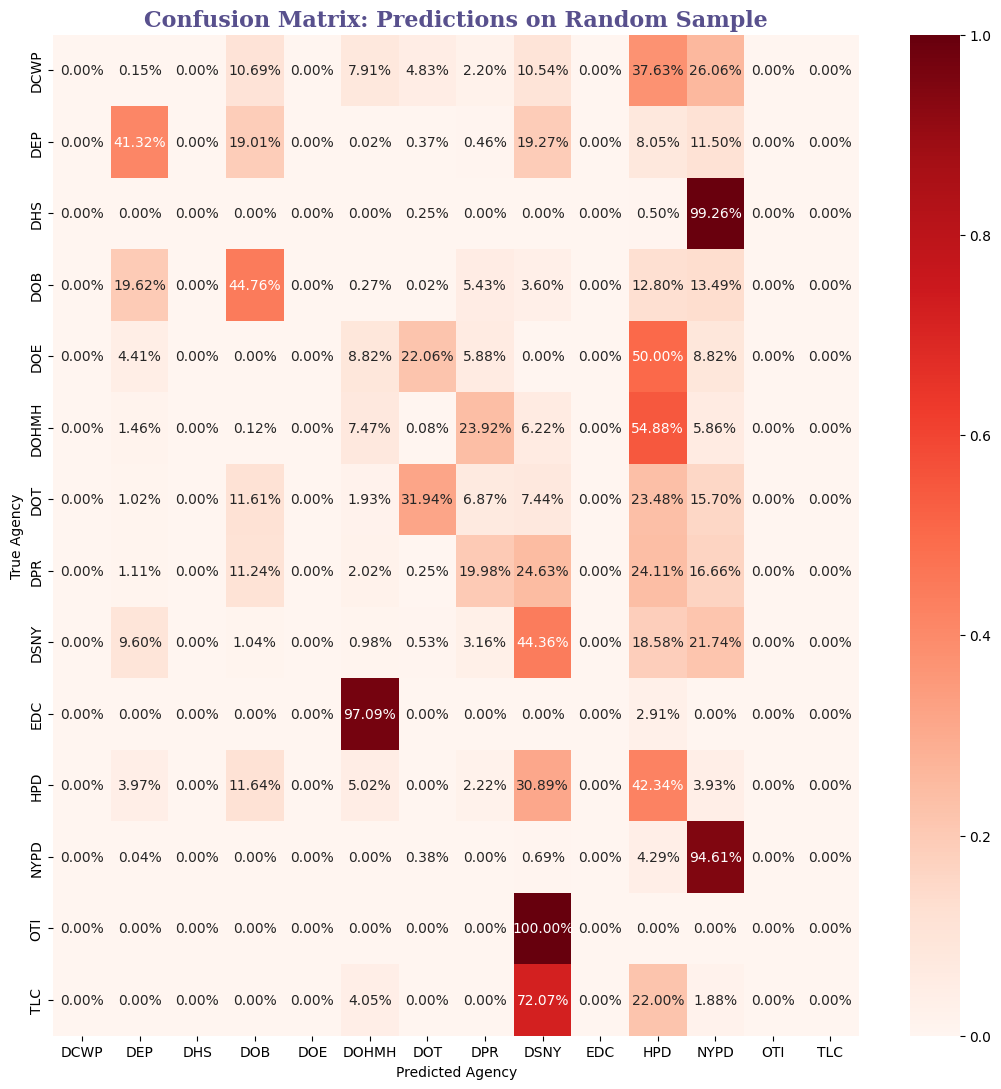

In [54]:

plt.figure(figsize=(13, 13))
plt.title('Confusion Matrix: Predictions on Random Sample',
          fontdict={'fontsize': 16, 'family': 'serif', 'color': '#58508d', 'weight': 'bold'})

sns.heatmap(cf_matrix, annot=True, xticklabels=le.classes_, yticklabels=le.classes_,
            fmt='.2%', cmap='Reds')
plt.ylabel('True Agency')
plt.xlabel('Predicted Agency')

The model correctly classified 95.51% of NYPD calls, 60.36% of HPD calls, and 15.5% of DOT calls, but still mis-classifies many calls in the minority classes.

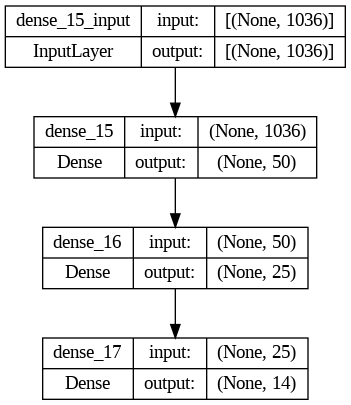

In [66]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import plot_model


# Plotting the model architecture
plot_model(model6, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


# LSTM Model

Long Short Term Memory (LSTM) recurrent neural network models are appropriate when the order of the input data matters. They are especially useful when working with natural language data, given that the order of words in a grouping of words can significantly change their meaning. Most of the 311 call descriptions are short, so there may be limited variation in the order of words within them. For perspective, the longest descriptor has been printed below.

In [55]:
#create dictionary and update it with each unique descriptor and its length
lengths = {}
for descriptor in df.descriptor:
  if descriptor not in lengths:
    lengths[descriptor] = len(descriptor)

#Get descriptor with the highest length value and print it
for descriptor, length in lengths.items():
  if len(descriptor) == max(lengths.values()):
    print('Descriptor:', descriptor)
    print('Length:', length)

Descriptor: safety netting guard rails  damaged inadequate none  stories  feet or less
Length: 74


The longest descriptor is only 74 characters. If there is little variation in the order of descriptor words due to their short length, we may not see much improvement in an LSTM model, but possible improvement is nonetheless worth investigating.

In [56]:
descriptors = X
tokenizer = Tokenizer()

tokenizer.fit_on_texts(descriptors)
descriptor_onehot = tokenizer.texts_to_sequences(descriptors)

#padding sequences ensures all sequences have the same length
descriptor_onehot = pad_sequences(descriptor_onehot)

In [57]:
#split the test and train data again with new descriptor data
test, train, label_test, label_train = train_test_split(descriptor_onehot,
                                                        agency_onehot,
                                                        test_size=.1,
                                                        random_state=6)

In [58]:
#store the shape in an object that will be used in the model's input dimensions
train_shape = train.shape

In [59]:
#create a model using an LSTM layer, with dropout to prevent overfitting

opt = tf.keras.optimizers.SGD(learning_rate=0.01)
model = Sequential()
model.add(layers.Embedding(input_dim=train_shape[0], output_dim=100))
model.add(layers.LSTM(64, dropout=0.1, activation='relu',return_sequences=True))
model.add(layers.GRU(14, recurrent_dropout=0.2, dropout=0.2))
model.add(Dropout(.2))
model.add(layers.Dense(14, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

We'll fit the LSTM model with an early stopping callback. This model has a longer training time than those built in the previous section. Implementing early stopping will ensure that the model does not continue to train after its improvement with each epoch becomes insignificant.

In [60]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(train, label_train, validation_data=(test, label_test),
                    epochs=150, batch_size=30, callbacks=[early_stopping])

Epoch 1/150
382/382 [==============================] - 63s 151ms/step - loss: 2.0632 - accuracy: 0.5107 - val_loss: 1.7374 - val_accuracy: 0.5110
Epoch 2/150
382/382 [==============================] - 59s 155ms/step - loss: 1.6988 - accuracy: 0.5121 - val_loss: 1.6461 - val_accuracy: 0.5110
Epoch 3/150
382/382 [==============================] - 59s 155ms/step - loss: 1.6451 - accuracy: 0.5129 - val_loss: 1.6178 - val_accuracy: 0.5110
Epoch 4/150
382/382 [==============================] - 46s 121ms/step - loss: 1.6227 - accuracy: 0.5130 - val_loss: 1.5989 - val_accuracy: 0.5110
Epoch 5/150
382/382 [==============================] - 58s 152ms/step - loss: 1.6039 - accuracy: 0.5148 - val_loss: 1.5776 - val_accuracy: 0.5110
Epoch 6/150
382/382 [==============================] - 59s 155ms/step - loss: 1.5778 - accuracy: 0.5166 - val_loss: 1.5466 - val_accuracy: 0.5110
Epoch 7/150
382/382 [==============================] - 44s 117ms/step - loss: 1.5350 - accuracy: 0.5254 - val_loss: 1.4979 -

With the early stopping callback, the model stopped training after 91 epochs. Below, we use modified code from the `plot_acc_loss()` function to visualize the model's learning history.

In [61]:
import plotly.graph_objects as go

# Assuming 'history' is your training history object

# Create subplots
fig = go.Figure()

# Define colors
color_accuracy_train = '#D8A7B1'
color_accuracy_val = '#05234C'
color_loss_train = '#D8A7B1'
color_loss_val = '#05234C'

# Plot Accuracy with dotted line
fig.add_trace(go.Scatter(x=list(range(1, len(history.history['accuracy']) + 1)),
                         y=history.history['accuracy'],
                         mode='lines',
                         name='Train Accuracy',
                         line=dict(color=color_accuracy_train, width=3, dash='dot')))

fig.add_trace(go.Scatter(x=list(range(1, len(history.history['val_accuracy']) + 1)),
                         y=history.history['val_accuracy'],
                         mode='lines',
                         name='Validation Accuracy',
                         line=dict(color=color_accuracy_val, width=3, dash='dot')))  # Dotted line for validation accuracy

# Set layout for Accuracy subplot
fig.update_layout(title='Model Accuracy',
                  xaxis=dict(title='Number of epochs'),
                  yaxis=dict(title='Accuracy'),
                  legend=dict(x=0, y=1, traceorder='normal', orientation='h'))

# Plot Loss
fig.add_trace(go.Scatter(x=list(range(1, len(history.history['loss']) + 1)),
                         y=history.history['loss'],
                         mode='lines',
                         name='Train Loss',
                         line=dict(color=color_loss_train, width=3)))

fig.add_trace(go.Scatter(x=list(range(1, len(history.history['val_loss']) + 1)),
                         y=history.history['val_loss'],
                         mode='lines',
                         name='Validation Loss',
                         line=dict(color=color_loss_val, width=3)))

# Set layout for Loss subplot
fig.update_layout(title='Model Evaluation Plot',
                  xaxis=dict(title='Number of epochs'),
                  yaxis=dict(title='Loss/Accuracy'),
                  legend=dict(x=0.75, y=0.9))

fig.show()


The model's performance on the validation data improved steadily alongside the training data across the 91 epochs. We'll now evaluate its accuracy on the random subset.

In [62]:
#create random sample test data with padded sequences
tokenizer.fit_on_texts(r_descriptors)
LSTM_r_descriptor_onehot = tokenizer.texts_to_sequences(r_descriptors)
LSTM_r_descriptor_onehot = pad_sequences(LSTM_r_descriptor_onehot)

In [63]:
#evaluate accuracy
LSTM_random_results = model.evaluate(LSTM_r_descriptor_onehot, r_agency_onehot, batch_size=30)

3845/3845 [==============================] - 36s 9ms/step - loss: 1.5501 - accuracy: 0.7390


In terms of accuracy scores on the random sample, the performance of the fourth model still exceeds that of the LSTM model. Different parameters could be tested on the LSTM model, but this process would be costly given the substantial increase in training time.

# Interpreting the Results
With 94% accuracy on the resampled test data, and 66.18% accuracy on the random subset, the fourth sequential model had the best overall performance.

# Conclusion and Recommendations
- Similar classification models can be developed to connect individuals with non-emergency government services by directing them to the appropriate responding agency. This potential application would require training on a larger, more varied set of descriptors. The evaluation of future models may also consider metrics other than accuracy to achieve a fuller understanding of their performance.
- Agencies should be attentive to how call volume tends to change based on certain temporal, geographic, and environmental factors. Many of these changes are intuitively expected: widespread tree damage following major weather events, noise calls peaking in the middle of the night, and overall call volume remaining consistently high in the most densely populated borough, Manhattan.
- Given that the majority of non-emergency requests are responded to by the same agency responsible for emergency requests, local stakeholders may wish to evaluate whether the current division of labor in handling 311 calls is optimal for meeting the needs of city residents. Amid growing concerns that law enforcement officers are over-utilized for intervention in non-emergency situations, this could be a fruitful area for further inquiry.
